# Praca Domowa 1

AutoML - Celem jest przeanalizowanie tunowalności hiperparametrów 3 wybranych algorytmów uczenia maszynowego na co najmniej 4 zbiorach danych. Do tunowania modeli należy wykorzystać min. 2 różne techniki losowania punktów.

autorzy: Michał Mazuryk, Wojciech Kosiuk

## Biblioteki

In [ ]:
!pip install openml smac

In [ ]:
import openml
import numpy as np
from ConfigSpace import Categorical, Configuration, ConfigurationSpace, Float, Integer
from ConfigSpace.conditions import InCondition
from sklearn.model_selection import train_test_split
from ConfigSpace import Configuration, ConfigurationSpace
from smac import HyperparameterOptimizationFacade, Scenario
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## Zbiory danych

In [ ]:
openml.datasets.list_datasets(output_format="dataframe")

# SPECT (binary)
dataset_1 = openml.datasets.get_dataset(336)
df_1 , _, _, _ = dataset_1.get_data(dataset_format="dataframe")

# Shrutime (binary)
dataset_2 = openml.datasets.get_dataset(45062)
df_2 , _, _, _ = dataset_2.get_data(dataset_format="dataframe")

# Bank-marketing (binary)
dataset_3 = openml.datasets.get_dataset(44126)
df_3 , _, _, _ = dataset_3.get_data(dataset_format="dataframe")

# Eye (binary)
dataset_4 = openml.datasets.get_dataset(1471)
df_4 , _, _, _ = dataset_4.get_data(dataset_format="dataframe")

/usr/local/lib/python3.10/dist-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/openml/datasets/functions.py:438: FutureWarning: Start

In [ ]:
df_1 = df_1.astype(int)
df_1.head()

,OVERALL_DIAGNOSIS,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22
0,1,0,0,0,1,0,0,0,1,1,...,1,1,0,0,0,0,0,0,0,0
1,1,0,0,1,1,0,0,0,1,1,...,1,1,0,0,0,0,0,0,0,1
2,1,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
4,1,0,0,0,0,0,0,0,1,0,...,1,0,1,1,0,0,0,0,0,0


In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   OVERALL_DIAGNOSIS  267 non-null    int64
 1   F1                 267 non-null    int64
 2   F2                 267 non-null    int64
 3   F3                 267 non-null    int64
 4   F4                 267 non-null    int64
 5   F5                 267 non-null    int64
 6   F6                 267 non-null    int64
 7   F7                 267 non-null    int64
 8   F8                 267 non-null    int64
 9   F9                 267 non-null    int64
 10  F10                267 non-null    int64
 11  F11                267 non-null    int64
 12  F12                267 non-null    int64
 13  F13                267 non-null    int64
 14  F14                267 non-null    int64
 15  F15                267 non-null    int64
 16  F16                267 non-null    int64
 17  F17             

In [ ]:
df_2.head()

,CreditScore,Age,Balance,EstimatedSalary,Geography,IsActiveMember,Tenure,Gender,HasCrCard,NumOfProducts,class
0,567,40,122265.24,138552.74,Germany,0,7,Male,1,1,0
1,636,24,0.00,38830.72,France,1,9,Female,0,2,0
2,745,48,96048.55,74510.65,Germany,0,10,Male,1,1,0
3,681,33,0.00,158336.36,Spain,0,10,Male,0,1,0
4,542,29,0.00,8342.35,France,0,9,Male,1,1,0


In [ ]:
df_2['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [ ]:
df_2['is_male'] = 0
df_2.loc[df_2['Gender'] == 'Male', 'is_male'] = 1
df_2['is_german'] = 0
df_2.loc[df_2['Geography'] == 'Germany', 'is_german'] = 1
df_2['is_french'] = 0
df_2.loc[df_2['Geography'] == 'France', 'is_french'] = 1

In [ ]:
df_2.drop(columns=['Gender','Geography'],inplace=True)

In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CreditScore      10000 non-null  int64   
 1   Age              10000 non-null  uint8   
 2   Balance          10000 non-null  float64 
 3   EstimatedSalary  10000 non-null  float64 
 4   IsActiveMember   10000 non-null  category
 5   Tenure           10000 non-null  category
 6   HasCrCard        10000 non-null  category
 7   NumOfProducts    10000 non-null  category
 8   class            10000 non-null  uint8   
 9   is_male          10000 non-null  int64   
 10  is_german        10000 non-null  int64   
 11  is_french        10000 non-null  int64   
dtypes: category(4), float64(2), int64(4), uint8(2)
memory usage: 528.3 KB


In [ ]:
df_3.head()

,V1,V6,V10,V12,V13,V14,V15,Class
0,52,51.0,14,935.0,2,-1.0,0,1
1,53,232.0,29,32.0,1,-1.0,0,1
2,50,525.0,18,177.0,2,-1.0,0,1
3,32,648.0,21,166.0,1,-1.0,0,1
4,58,2348.0,9,226.0,1,-1.0,0,1


In [ ]:
df_3['Class'] = df_3['Class'].astype(int)

In [ ]:
df_3.loc[df_3.Class==2, 'Class']=0

In [ ]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10578 entries, 0 to 10577
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      10578 non-null  uint8  
 1   V6      10578 non-null  float64
 2   V10     10578 non-null  uint8  
 3   V12     10578 non-null  float64
 4   V13     10578 non-null  uint8  
 5   V14     10578 non-null  float64
 6   V15     10578 non-null  uint8  
 7   Class   10578 non-null  int64  
dtypes: float64(3), int64(1), uint8(4)
memory usage: 372.0 KB


In [ ]:
df_4.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,Class
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,1
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,1
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,1
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,1
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,1


In [ ]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   V1      14980 non-null  float64 
 1   V2      14980 non-null  float64 
 2   V3      14980 non-null  float64 
 3   V4      14980 non-null  float64 
 4   V5      14980 non-null  float64 
 5   V6      14980 non-null  float64 
 6   V7      14980 non-null  float64 
 7   V8      14980 non-null  float64 
 8   V9      14980 non-null  float64 
 9   V10     14980 non-null  float64 
 10  V11     14980 non-null  float64 
 11  V12     14980 non-null  float64 
 12  V13     14980 non-null  float64 
 13  V14     14980 non-null  float64 
 14  Class   14980 non-null  category
dtypes: category(1), float64(14)
memory usage: 1.6 MB


## Finding Default Params


In [ ]:
y_1 = df_1['OVERALL_DIAGNOSIS']
X_1 = df_1.drop(columns=['OVERALL_DIAGNOSIS'])
y_2 = df_2['class']
X_2 = df_2.drop(columns=['class'])
y_3 = df_3['Class']
X_3 = df_3.drop(columns=['Class'])
y_4 = df_4['Class']
X_4 = df_4.drop(columns=['Class'])

X_list = [X_1,X_2,X_3,X_4]
y_list = [y_1,y_2,y_3,y_4]

In [ ]:
def find_def(X_list,y_list,classifier,params):
  i = 1
  columns_to_display = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score','dataset_n']
  df_list = []

  for X,y in zip(X_list,y_list):

    grid_search = GridSearchCV(estimator=classifier, param_grid=params, cv=3, scoring='roc_auc')
    grid_search.fit(X, y)

    results = pd.DataFrame(grid_search.cv_results_)
    results['dataset_n'] = i
    df_list.append(results[columns_to_display])

    print(f"fitting completed for {i} dataset")
    i=i+1

  df_r = df_list[0].reset_index()

  df_r = pd.merge(df_r,df_list[1].reset_index(),on='index',suffixes=("","_2"))
  df_r = pd.merge(df_r,df_list[2].reset_index(),on='index',suffixes=("","_3"))
  df_r = pd.merge(df_r,df_list[3].reset_index(),on='index',suffixes=("_1","_4"))

  df_r['mean_def'] = df_r[['mean_test_score_1','mean_test_score_2','mean_test_score_3','mean_test_score_4']].mean(axis=1)
  df_r = df_r[['params_1','mean_def','mean_test_score_1','mean_test_score_2','mean_test_score_3','mean_test_score_4']]

  return df_r, df_list

### RandomForest

In [ ]:
# Random Forest Hyperparameters
param_grid = {
      'n_estimators': [50, 100, 200],
      'max_depth': [5, 10, 20],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [2, 5, 8]
  }

rf_classifier = RandomForestClassifier()

df_rf, df_list_rf = find_def(X_list,y_list,rf_classifier,param_grid)

In [2]:
df_rf.sort_values(by='mean_def',ascending=False).head(10)

,Unnamed: 0,params_1,mean_def,mean_test_score_1,mean_test_score_2,mean_test_score_3,mean_test_score_4
46,46,"{'max_depth': 10, 'min_samples_leaf': 8, 'min_...",0.756868,0.841867,0.861775,0.829161,0.494668
6,6,"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s...",0.756495,0.847083,0.851121,0.810514,0.517261
23,23,"{'max_depth': 5, 'min_samples_leaf': 8, 'min_s...",0.756210,0.844214,0.849526,0.814950,0.516149
38,38,"{'max_depth': 10, 'min_samples_leaf': 5, 'min_...",0.756058,0.844015,0.862086,0.828217,0.489914
47,47,"{'max_depth': 10, 'min_samples_leaf': 8, 'min_...",0.755512,0.838588,0.862510,0.829509,0.491440
48,48,"{'max_depth': 10, 'min_samples_leaf': 8, 'min_...",0.755063,0.837402,0.861429,0.828124,0.493297
22,22,"{'max_depth': 5, 'min_samples_leaf': 8, 'min_s...",0.754989,0.843181,0.848235,0.809866,0.518674
20,20,"{'max_depth': 5, 'min_samples_leaf': 8, 'min_s...",0.754981,0.836722,0.849436,0.814138,0.519629
18,18,"{'max_depth': 5, 'min_samples_leaf': 8, 'min_s...",0.754870,0.839964,0.847373,0.816699,0.515446
52,52,"{'max_depth': 10, 'min_samples_leaf': 8, 'min_...",0.754838,0.842598,0.862303,0.829571,0.484879


In [3]:
#top5 params
print(df_rf.loc[46,'params_1'])
print(df_rf.loc[6,'params_1'])
print(df_rf.loc[23,'params_1'])
print(df_rf.loc[38,'params_1'])
print(df_rf.loc[47,'params_1'])

{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 100}
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
{'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 200}
{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}
{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
df_rf.to_csv('df_rf_default.csv')

### LightGBM

In [ ]:
import lightgbm as lgb

param_grid = {
    'n_estimators': [20, 100, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 7, 10],
    'num_leaves': [10, 31, 65, 100]
}

lgb_classifier = lgb.LGBMClassifier()

df_lgb, df_list_lgb = find_def(X_list,y_list,lgb_classifier,param_grid)

In [ ]:
df_lgb.sort_values(by='mean_def',ascending=False).head(10)

,params_1,mean_def,mean_test_score_1,mean_test_score_2,mean_test_score_3,mean_test_score_4
9,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.750787,0.819421,0.856733,0.823303,0.503690
8,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.750787,0.819421,0.856733,0.823303,0.503690
11,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.750787,0.819421,0.856733,0.823303,0.503690
10,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.750787,0.819421,0.856733,0.823303,0.503690
20,"{'learning_rate': 0.01, 'max_depth': 7, 'n_est...",0.750557,0.818920,0.862896,0.832787,0.487627
32,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.750450,0.818920,0.862953,0.833023,0.486903
48,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.747961,0.816542,0.857337,0.828116,0.489850
36,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.747690,0.818828,0.848578,0.816257,0.507096
39,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.747690,0.818828,0.848578,0.816257,0.507096
37,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.747690,0.818828,0.848578,0.816257,0.507096


In [ ]:
#top5 params
print(df_lgb.loc[9,'params_1'])
print(df_lgb.loc[8,'params_1'])
print(df_lgb.loc[11,'params_1'])
print(df_lgb.loc[10,'params_1'])
print(df_lgb.loc[20,'params_1'])

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'num_leaves': 31}
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'num_leaves': 10}
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'num_leaves': 100}
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'num_leaves': 65}
{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'num_leaves': 10}


### XGBoost

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_1 = le.fit_transform(y_1)
le = LabelEncoder()
y_3 = le.fit_transform(y_3)
le = LabelEncoder()
y_4 = le.fit_transform(y_4)
y_list = [y_1,y_2,y_3,y_4]

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.001, 0.005, 0.01,0.02]
}

xgb_classifier = XGBClassifier(enable_categorical=True)

df_xg, df_list_xg = find_def(X_list,y_list,xgb_classifier,param_grid)

fitting completed for 1 dataset
fitting completed for 2 dataset
fitting completed for 3 dataset
fitting completed for 4 dataset


In [ ]:
df_xg.sort_values(by='mean_def',ascending=False).head(10)

,params_1,mean_def,mean_test_score_1,mean_test_score_2,mean_test_score_3,mean_test_score_4
38,"{'learning_rate': 0.02, 'max_depth': 3, 'n_est...",0.752520,0.824827,0.861022,0.826284,0.497949
26,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.747465,0.813087,0.851454,0.815223,0.510098
37,"{'learning_rate': 0.02, 'max_depth': 3, 'n_est...",0.746694,0.811271,0.851409,0.815112,0.508984
16,"{'learning_rate': 0.005, 'max_depth': 5, 'n_es...",0.744955,0.809898,0.850076,0.821365,0.498482
27,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.744910,0.810399,0.850113,0.821496,0.497632
41,"{'learning_rate': 0.02, 'max_depth': 5, 'n_est...",0.743195,0.822244,0.862483,0.826697,0.461355
15,"{'learning_rate': 0.005, 'max_depth': 5, 'n_es...",0.743059,0.805277,0.843236,0.817567,0.506154
5,"{'learning_rate': 0.001, 'max_depth': 5, 'n_es...",0.742933,0.804748,0.841045,0.815711,0.510229
4,"{'learning_rate': 0.001, 'max_depth': 5, 'n_es...",0.742683,0.802655,0.837501,0.810393,0.520181
28,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.742483,0.806157,0.854218,0.822675,0.486884


In [ ]:
#top5 params
print(df_xg.loc[38,'params_1'])
print(df_xg.loc[26,'params_1'])
print(df_xg.loc[37,'params_1'])
print(df_xg.loc[16,'params_1'])
print(df_xg.loc[27,'params_1'])

{'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 200}
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
{'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 100}
{'learning_rate': 0.005, 'max_depth': 5, 'n_estimators': 100}
{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}


In [ ]:
df_xg.to_csv('df_xg_default.csv')

## Random Search

#### FUNCTIONS

In [ ]:
y_1 = df_1['OVERALL_DIAGNOSIS']
X_1 = df_1.drop(columns=['OVERALL_DIAGNOSIS'])
y_2 = df_2['class']
X_2 = df_2.drop(columns=['class'])
y_3 = df_3['Class']
X_3 = df_3.drop(columns=['Class'])
y_4 = df_4['Class']
X_4 = df_4.drop(columns=['Class'])

X_list = [X_1,X_2,X_3,X_4]
y_list = [y_1,y_2,y_3,y_4]

In [ ]:
def find_rs(X_list,y_list,classifier,params,n_iterations,r_s):
  i = 1
  columns_to_display = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score','dataset_n']
  df_list = []

  for X,y in zip(X_list,y_list):

    random_search = RandomizedSearchCV(estimator=classifier, param_distributions=params, n_iter=n_iterations, cv=3, scoring='roc_auc', random_state=r_s)
    random_search.fit(X,y)

    results = pd.DataFrame(random_search.cv_results_)
    results['dataset_n'] = i
    df_list.append(results[columns_to_display])

    print(f"fitting completed for {i} dataset")
    i=i+1

  df_r = df_list[0].reset_index()

  df_r = pd.merge(df_r,df_list[1].reset_index(),on='index',suffixes=("","_2"))
  df_r = pd.merge(df_r,df_list[2].reset_index(),on='index',suffixes=("","_3"))
  df_r = pd.merge(df_r,df_list[3].reset_index(),on='index',suffixes=("_1","_4"))

  df_r['mean_def'] = df_r[['mean_test_score_1','mean_test_score_2','mean_test_score_3','mean_test_score_4']].mean(axis=1)
  df_r = df_r[['params_1','mean_def','mean_test_score_1','mean_test_score_2','mean_test_score_3','mean_test_score_4']]

  return df_r, df_list

In [ ]:
def plot_auc(i,x,y_):
  plt.subplot(4, 1, i+1)
  plt.plot(x, y_[0], label='seed 1.')
  plt.plot(x, y_[1], label='seed 2.')
  plt.plot(x, y_[2], label='seed 3.')

  plt.title(f'AUC for Dataset {i+1} across iterations of RandomSearch')
  plt.xlabel('Iteration')
  plt.ylabel('Auc')
  plt.legend()

In [ ]:
def find_list_across_seeds(df_results_list,t_state_list):

  best_auc_list = []
  best_params_list = []

  for j in range(1,5):
    auc = []
    param = []
    for i in range(len(t_state_list)):

      df_seed = df_results_list[i][0]
      auc.append(max(df_seed['mean_test_score_'+str(j)]))
      param.append(df_seed.loc[df_seed['mean_test_score_'+str(j)].idxmax(),'params_1'])
    best_auc_list.append(auc)
    best_params_list.append(param)


  return best_auc_list,best_params_list


In [ ]:
def find_param_list_across_seeds(df_results_list,param,_state_list):
  best_auc_list = [] # 1. [] which param 2. [] which dataset 3. [] which randomstate
  best_params_list = []

  for p in range(len(param)):
    auc = []
    param_ = []
    for j in range(1,5):
      auc_list = []
      param_list = []
      for i in range(len(_state_list)):

        df_seed = df_results_list[p][i]
        auc_list.append(max(df_seed['mean_test_score_'+str(j)]))
        param_list.append(df_seed.loc[df_seed['mean_test_score_'+str(j)].idxmax(),'params_1'])
      auc.append(auc_list)
      param_.append(param_list)
    best_auc_list.append(auc)
    best_params_list.append(param_)

  for p in range(len(param)):
    print(f"Parameter: {param[p]}")
    for j in range(4):
      print(f"Dataset {j+1} AUC: {best_auc_list[p][j]}")
      for s in range(3):
        print(f"{param[p]} = {best_params_list[p][j][s][param[p]]}")

  return best_auc_list,best_params_list

### RandomForest

In [ ]:
param_grid = {
    'n_estimators': [i for i in range(50,201)],
    'max_depth': [i for i in range(5,21)],
    'min_samples_split': [i for i in range(2,11)],
    'min_samples_leaf': [i for i in range(2,9)]
  }

rf_classifier = RandomForestClassifier()
r_state_list = [48,210,36]
df_results_list = []

for r_state in(r_state_list):
  df_res,df_list_res = find_rs(X_list,y_list,rf_classifier,param_grid,40,r_state)
  df_results_list.append([df_res,df_list_res])

fitting completed for 1 dataset
fitting completed for 2 dataset
fitting completed for 3 dataset
fitting completed for 4 dataset
fitting completed for 1 dataset
fitting completed for 2 dataset
fitting completed for 3 dataset
fitting completed for 4 dataset
fitting completed for 1 dataset
fitting completed for 2 dataset
fitting completed for 3 dataset
fitting completed for 4 dataset


#### BEST

In [ ]:
best_auc_list, best_params_list  = find_list_across_seeds(df_results_list,r_state_list)

In [ ]:
best_auc_list

[[0.8445976051239209, 0.8451090558948232, 0.8473544973544973],
 [0.8626911440306958, 0.8627934024018993, 0.8628188480512179],
 [0.8296068628614895, 0.8303604683872295, 0.8301248527133928],
 [0.5213942150877581, 0.5236461659903227, 0.5162285795217817]]

In [ ]:
print(best_params_list[0])
print(best_params_list[1])
print(best_params_list[2])

[{'n_estimators': 83, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 6}, {'n_estimators': 116, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_depth': 20}, {'n_estimators': 89, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 6}]
[{'n_estimators': 190, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_depth': 10}, {'n_estimators': 154, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_depth': 10}, {'n_estimators': 170, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_depth': 9}]
[{'n_estimators': 131, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_depth': 14}, {'n_estimators': 198, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_depth': 15}, {'n_estimators': 100, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_depth': 13}]


diff:
[0.0038200527910803306, 0.000992798161271069, 0.0008697279873706165, 0.02575498686662081]
mean:
0.007859391451585707


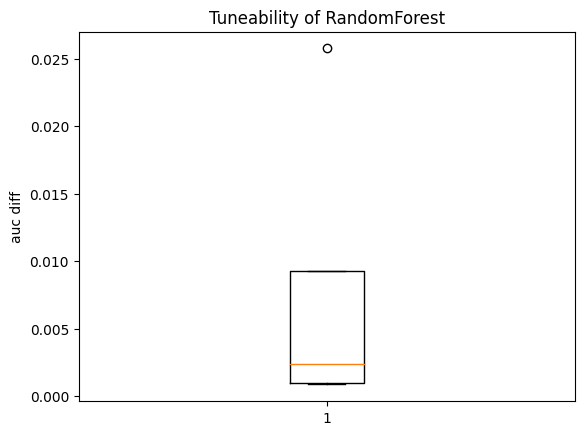

In [ ]:
default_rf_auc = [0.841867,	0.861775,	0.829161,	0.494668]
tun_rf = []

for i in range(len(default_rf_auc)):
  tun_rf.append(np.mean(best_auc_list[i])-default_rf_auc[i])

print("diff:")
print(tun_rf)
print("mean:")
print(np.mean(tun_rf))
plt.boxplot(tun_rf)

plt.title('Tuneability of RandomForest')
plt.xlabel('')
plt.ylabel('auc diff')

plt.show()

#### ITERATIONS

In [ ]:
auc_list = []

for j in range(1,5):
  auc = []
  for i in range(len(r_state_list)):
    df_seed = df_results_list[i][0]
    auc_l = []

    for k in range(len(df_seed)):
      auc_l.append(max(df_seed.loc[:k,'mean_test_score_'+str(j)]))

    auc.append(auc_l)
  auc_list.append(auc)


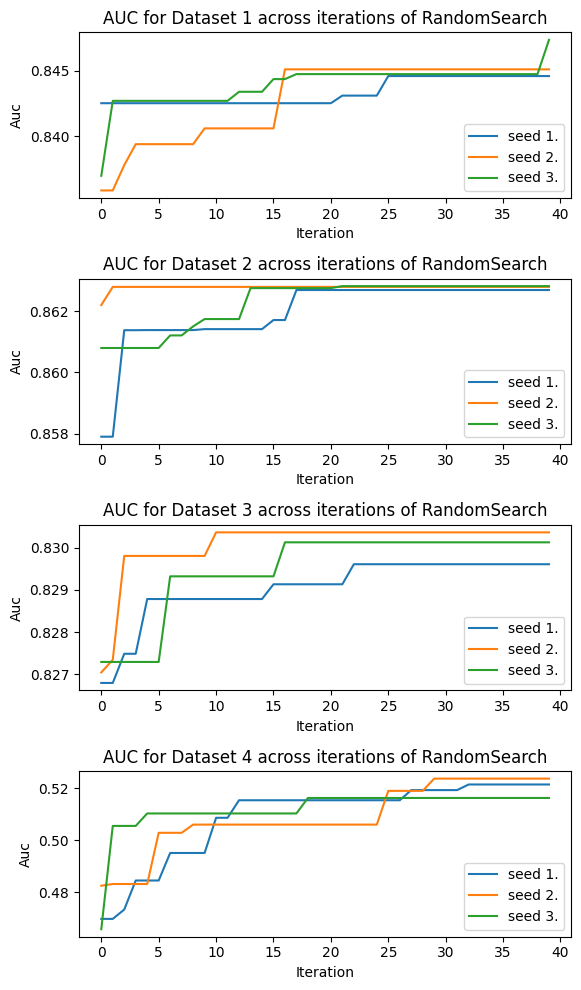

In [ ]:
x = [i for i in range(40)]

plt.figure(figsize=(6, 10))
for i in range(4):
  plot_auc(i,x,auc_list[i])

plt.tight_layout()
plt.show()

#### TUNEABILITY FOR PARAMS

In [ ]:
default = {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 100}

In [ ]:
param = ['max_depth','min_samples_leaf','min_samples_split', 'n_estimators']

#wider grid
param_grid = {
    'n_estimators': [i for i in range(50,201)],
    'max_depth': [i for i in range(2,31)],
    'min_samples_split': [i for i in range(2,21)],
    'min_samples_leaf': [i for i in range(2,19)]
  }

rf_classifier = RandomForestClassifier()
r_state_list = [48,210,36]
df_results_list = []

for param_ in param:
  default_i = {'max_depth': [10], 'min_samples_leaf': [8], 'min_samples_split': [2], 'n_estimators': [100]}
  print(param_)
  default_i[param_] = param_grid[param_]

  df_result_param = []
  for r_state in(r_state_list):
    df_res,_ = find_rs(X_list,y_list,rf_classifier,default_i,8,r_state)
    df_result_param.append(df_res)

  df_results_list.append(df_result_param)

In [ ]:
find_param_list_across_seeds(df_results_list,param,r_state_list)

Parameter: max_depth
Dataset 1 AUC: [0.8434421342872046, 0.8436417726632701, 0.8420972227124932]
max_depth = 27
max_depth = 17
max_depth = 9
Dataset 2 AUC: [0.8612970778606973, 0.8614153612230226, 0.8618675321942629]
max_depth = 17
max_depth = 22
max_depth = 9
Dataset 3 AUC: [0.830804781421688, 0.8297339473282609, 0.829979965696846]
max_depth = 29
max_depth = 30
max_depth = 17
Dataset 4 AUC: [0.5161681543567118, 0.5203850618951734, 0.4920379053557409]
max_depth = 5
max_depth = 2
max_depth = 9
Parameter: min_samples_leaf
Dataset 1 AUC: [0.8413963312035958, 0.8366709026086342, 0.8390693086393606]
min_samples_leaf = 4
min_samples_leaf = 11
min_samples_leaf = 5
Dataset 2 AUC: [0.8625703265051149, 0.863193182992994, 0.862293939752985]
min_samples_leaf = 7
min_samples_leaf = 5
min_samples_leaf = 8
Dataset 3 AUC: [0.8299602327501067, 0.8296877250454099, 0.8298558840697958]
min_samples_leaf = 17
min_samples_leaf = 13
min_samples_leaf = 15
Dataset 4 AUC: [0.49377787592198913, 0.4926968493938378

For max_depth diff across datasets: [0.0011933765543226116, -0.0002483429073388832, 0.0010118981489316559, 0.014862373869208745]
Mean: 0.004204826416281032

For min_samples_leaf diff across datasets: [-0.0028214858494698403, 0.0009108164170312794, 0.0006736139551041243, -0.0021087735516733264]
Mean: -0.0008364572572519408

For min_samples_split diff across datasets: [-0.00010590712697244875, 0.000564039345304912, 0.0003446421392214738, -0.0013356865463999834]
Mean: -0.0001332280472115116

For n_estimators diff across datasets: [0.00039194679316967296, 0.0008804091054105401, 0.0013268030906442574, -0.002646769272324767]
Mean: -1.1902570775074173e-05



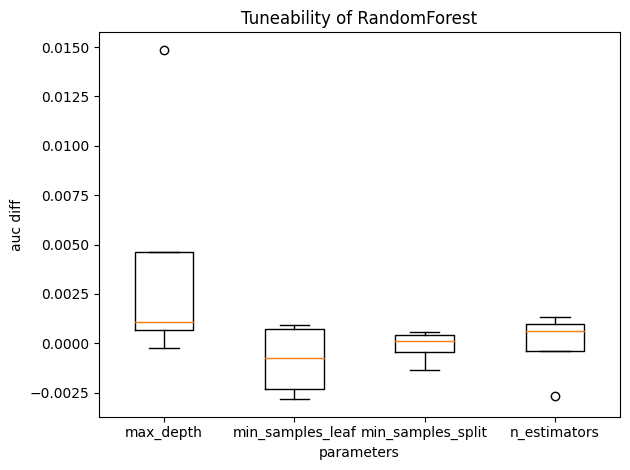

In [ ]:
default_rf_auc = [0.841867,	0.861775,	0.829161,	0.494668]
tun_param_rf = []

for p in range(len(param)):
  param_diff = []
  for i in range(len(default_rf_auc)):
    param_diff.append(default_rf_auc[i]-np.mean(best_auc_list[p][i]))
  tun_param_rf.append(param_diff)

for p in range(len(param)):
  print(f"For {param[p]} diff across datasets: {tun_param_rf[p]}")
  print(f"Mean: {np.mean(tun_param_rf[p])}")
  print("")
plt.boxplot(tun_param_rf, labels=param)
plt.title('Tuneability of RandomForest')
plt.xlabel('parameters')
plt.ylabel('auc diff')
plt.tight_layout()
plt.show()

### XGBoost

In [ ]:
le = LabelEncoder()
y_1 = le.fit_transform(y_1)
le = LabelEncoder()
y_3 = le.fit_transform(y_3)
le = LabelEncoder()
y_4 = le.fit_transform(y_4)
y_list = [y_1,y_2,y_3,y_4]

In [ ]:
param_grid = {
    'n_estimators': [i for i in range(50,201)],
    'max_depth': [i for i in range(3,11)],
    'learning_rate': [i/1000 for i in range(1,201)],
  }


xgb_classifier = XGBClassifier(enable_categorical=True)
x_state_list = [48,210,36]
df_results_list = []

for x_state in(x_state_list):
  df_res,df_list_res = find_rs(X_list,y_list,xgb_classifier,param_grid,40,x_state)
  df_results_list.append([df_res,df_list_res])

fitting completed for 1 dataset
fitting completed for 2 dataset
fitting completed for 3 dataset
fitting completed for 4 dataset
fitting completed for 1 dataset
fitting completed for 2 dataset
fitting completed for 3 dataset
fitting completed for 4 dataset
fitting completed for 1 dataset
fitting completed for 2 dataset
fitting completed for 3 dataset
fitting completed for 4 dataset


#### BEST

In [ ]:
best_auc_list, best_params_list  = find_list_across_seeds(df_results_list,x_state_list)

In [ ]:
best_auc_list

[[0.8295011786116309, 0.8237987378461803, 0.8234767278132734],
 [0.8659205045764139, 0.8658070341665575, 0.865230272989403],
 [0.8307435985623691, 0.8307986148758321, 0.8283355892166738],
 [0.49840800188844164, 0.5015805531019425, 0.4775317302957649]]

In [ ]:
print(best_params_list[0])
print(best_params_list[1])
print(best_params_list[2])

[{'n_estimators': 158, 'max_depth': 3, 'learning_rate': 0.027}, {'n_estimators': 69, 'max_depth': 3, 'learning_rate': 0.051}, {'n_estimators': 58, 'max_depth': 5, 'learning_rate': 0.085}]
[{'n_estimators': 154, 'max_depth': 3, 'learning_rate': 0.094}, {'n_estimators': 148, 'max_depth': 3, 'learning_rate': 0.094}, {'n_estimators': 79, 'max_depth': 3, 'learning_rate': 0.188}]
[{'n_estimators': 154, 'max_depth': 3, 'learning_rate': 0.094}, {'n_estimators': 148, 'max_depth': 3, 'learning_rate': 0.094}, {'n_estimators': 87, 'max_depth': 4, 'learning_rate': 0.073}]


diff:
[0.0007652147570281764, 0.004630603910791509, 0.00367526755162495, -0.005442238237950259]
mean:
0.0009072119953735941


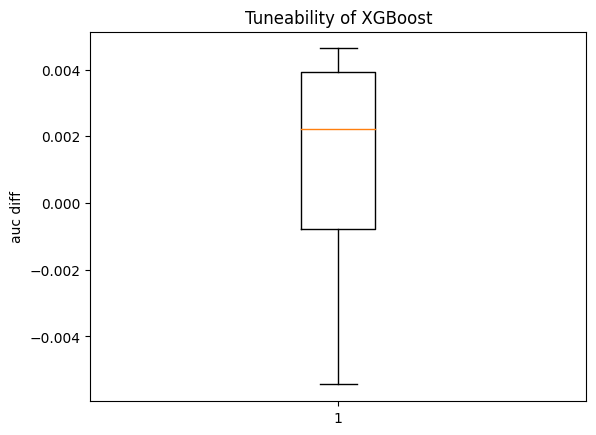

In [ ]:
default_xg_auc = [0.824827,	0.861022,	0.826284,	0.497949]
tun_rf = []

for i in range(len(default_xg_auc)):
  tun_rf.append(np.mean(best_auc_list[i])-default_xg_auc[i])

print("diff:")
print(tun_rf)
print("mean:")
print(np.mean(tun_rf))
plt.boxplot(tun_rf)

plt.title('Tuneability of XGBoost')
plt.xlabel('')
plt.ylabel('auc diff')

plt.show()

#### ITERATIONS

In [ ]:
auc_list = []

for j in range(1,5):
  auc = []
  for i in range(len(x_state_list)):
    df_seed = df_results_list[i][0]
    auc_l = []

    for k in range(len(df_seed)):
      auc_l.append(max(df_seed.loc[:k,'mean_test_score_'+str(j)]))

    auc.append(auc_l)
  auc_list.append(auc)

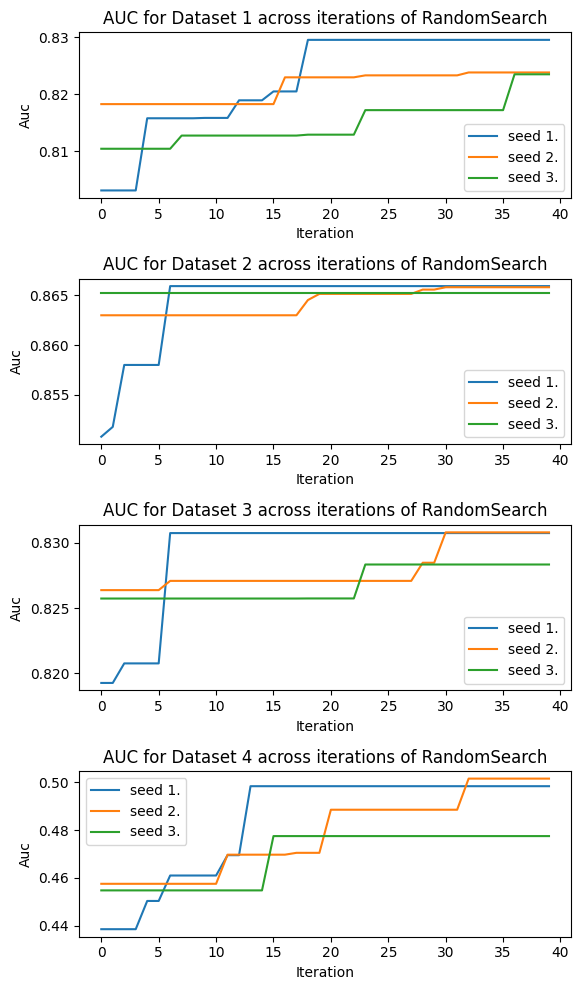

In [ ]:
x = [i for i in range(40)]

plt.figure(figsize=(6, 10))
for i in range(4):
  plot_auc(i,x,auc_list[i])

plt.tight_layout()
plt.show()

#### TUNEABILITY FOR PARAMS

In [ ]:
default = {'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 200}

In [ ]:
param = ['learning_rate','max_depth', 'n_estimators']

#wider grid
param_grid = {
    'n_estimators': [i for i in range(50,201)],
    'max_depth': [i for i in range(2,14)],
    'learning_rate': [i/1000 for i in range(1,201)],
  }


xgb_classifier = XGBClassifier(enable_categorical=True)

r_state_list = [48,210,36]
df_results_list = []

for param_ in param:
  default_i = {'max_depth': [3], 'learning_rate': [0.02], 'n_estimators': [200]}
  print(param_)
  default_i[param_] = param_grid[param_]

  df_result_param = []
  for r_state in(r_state_list):
    df_res,_ = find_rs(X_list,y_list,xgb_classifier,default_i,8,r_state)
    df_result_param.append(df_res)

  df_results_list.append(df_result_param)

learning_rate
fitting completed for 1 dataset
fitting completed for 2 dataset
fitting completed for 3 dataset
fitting completed for 4 dataset
fitting completed for 1 dataset
fitting completed for 2 dataset
fitting completed for 3 dataset
fitting completed for 4 dataset
fitting completed for 1 dataset
fitting completed for 2 dataset
fitting completed for 3 dataset
fitting completed for 4 dataset
max_depth
fitting completed for 1 dataset
fitting completed for 2 dataset
fitting completed for 3 dataset
fitting completed for 4 dataset
fitting completed for 1 dataset
fitting completed for 2 dataset
fitting completed for 3 dataset
fitting completed for 4 dataset
fitting completed for 1 dataset
fitting completed for 2 dataset
fitting completed for 3 dataset
fitting completed for 4 dataset
n_estimators
fitting completed for 1 dataset
fitting completed for 2 dataset
fitting completed for 3 dataset
fitting completed for 4 dataset
fitting completed for 1 dataset
fitting completed for 2 dataset
fit

In [ ]:
best_auc_list,best_params_list = find_param_list_across_seeds(df_results_list,param,x_state_list)

Parameter: learning_rate
Dataset 1 AUC: [0.8267289899239492, 0.8293809641474579, 0.8104602272504423]
learning_rate = 0.032
learning_rate = 0.026
learning_rate = 0.053
Dataset 2 AUC: [0.8657976498410745, 0.8655419998722275, 0.8659529830965744]
learning_rate = 0.079
learning_rate = 0.081
learning_rate = 0.053
Dataset 3 AUC: [0.8306821475923606, 0.8283697465185024, 0.8301238338927731]
learning_rate = 0.042
learning_rate = 0.03
learning_rate = 0.053
Dataset 4 AUC: [0.4850932725247617, 0.5096601012583253, 0.4680548109462673]
learning_rate = 0.032
learning_rate = 0.007
learning_rate = 0.053
Parameter: max_depth
Dataset 1 AUC: [0.8273992885186362, 0.8313473433191744, 0.8313473433191744]
max_depth = 4
max_depth = 2
max_depth = 2
Dataset 2 AUC: [0.8634722000873086, 0.8634722000873086, 0.8624825395618719]
max_depth = 4
max_depth = 4
max_depth = 5
Dataset 3 AUC: [0.8261342395903611, 0.8266972720380821, 0.8266972720380821]
max_depth = 4
max_depth = 5
max_depth = 5
Dataset 4 AUC: [0.486098476609026

For learning_rate diff across datasets: [-0.002636939559383489, 0.004742210936625524, 0.003441242667878597, -0.010346271756881908]
Mean: -0.0011999394279403192

For max_depth diff across datasets: [0.0052043250523282625, 0.0021203132454964413, 0.00022559455550841268, -0.0009804702643517182]
Mean: 0.0016424406472453495

For n_estimators diff across datasets: [0.0006857908451358696, -0.0009309771275373135, -0.001265351114148272, 0.01189921654627979]
Mean: 0.0025971697874325184



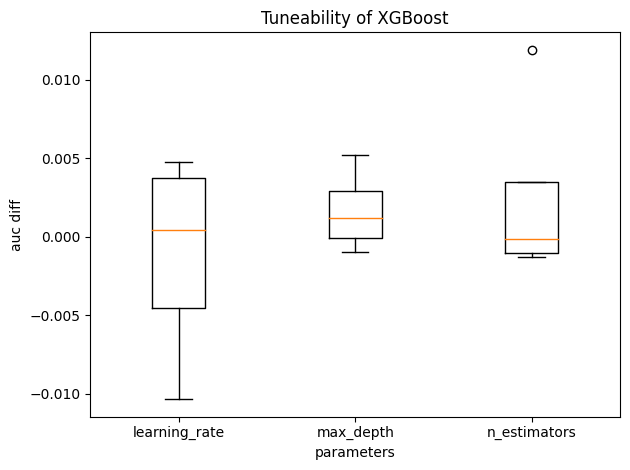

In [ ]:
default_xg_auc = [0.824827,	0.861022,	0.826284,	0.497949]
tun_param_xg = []

for p in range(len(param)):
  param_diff = []
  for i in range(len(default_xg_auc)):
    param_diff.append(np.mean(best_auc_list[p][i])-default_xg_auc[i])
  tun_param_xg.append(param_diff)

for p in range(len(param)):
  print(f"For {param[p]} diff across datasets: {tun_param_xg[p]}")
  print(f"Mean: {np.mean(tun_param_xg[p])}")
  print("")
plt.boxplot(tun_param_xg, labels=param)
plt.title('Tuneability of XGBoost')
plt.xlabel('parameters')
plt.ylabel('auc diff')
plt.tight_layout()
plt.show()

### LightGBM

In [ ]:
import lightgbm as lgb

param_grid = {
    'n_estimators': [i for i in range(20,301)],
    'learning_rate': [i/1000 for i in range(1,301)],
    'max_depth': [i for i in range(3,11)],
    'num_leaves': [i for i in range(10,101)]
}

lgb_classifier = lgb.LGBMClassifier()
lgb_state_list = [48,210,36]
df_results_list = []

for l_state in(lgb_state_list):
  df_res,df_list_res = find_rs(X_list,y_list,lgb_classifier,param_grid,40,l_state)
  df_results_list.append([df_res,df_list_res])

#### BEST

In [ ]:
best_auc_list, best_params_list  = find_list_across_seeds(df_results_list,lgb_state_list)

In [ ]:
best_auc_list

[[0.8233688681798391, 0.8276907056373327, 0.8219445326932354],
 [0.8662978161532889, 0.8663654475670034, 0.8659500781166937],
 [0.8311280692909554, 0.8328416719511283, 0.8333319927798865],
 [0.5078299105439499, 0.5246352758411795, 0.5048525657404411]]

In [ ]:
print(best_params_list[0])
print(best_params_list[1])
print(best_params_list[2])

[{'num_leaves': 82, 'n_estimators': 47, 'max_depth': 9, 'learning_rate': 0.097}, {'num_leaves': 90, 'n_estimators': 29, 'max_depth': 8, 'learning_rate': 0.13}, {'num_leaves': 91, 'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.148}]
[{'num_leaves': 22, 'n_estimators': 108, 'max_depth': 3, 'learning_rate': 0.124}, {'num_leaves': 14, 'n_estimators': 179, 'max_depth': 6, 'learning_rate': 0.041}, {'num_leaves': 28, 'n_estimators': 38, 'max_depth': 4, 'learning_rate': 0.193}]
[{'num_leaves': 18, 'n_estimators': 107, 'max_depth': 8, 'learning_rate': 0.062}, {'num_leaves': 33, 'n_estimators': 135, 'max_depth': 9, 'learning_rate': 0.011}, {'num_leaves': 16, 'n_estimators': 72, 'max_depth': 7, 'learning_rate': 0.028}]


diff:
[0.004913702170135759, 0.009471447278995404, 0.009130911340656689, 0.008749250708523504]
mean:
0.008066327874577839


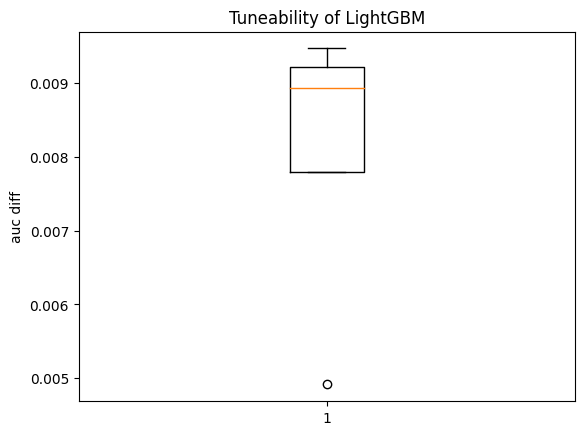

In [ ]:
default_lgb_auc  = [0.819421, 0.856733, 0.823303, 0.503690]
tun_lgb = []

for i in range(len(default_lgb_auc)):
  tun_lgb.append(np.mean(best_auc_list[i])-default_lgb_auc[i])

print("diff:")
print(tun_lgb)
print("mean:")
print(np.mean(tun_lgb))
plt.boxplot(tun_lgb)

plt.title('Tuneability of LightGBM')
plt.xlabel('')
plt.ylabel('auc diff')

plt.show()

#### ITERATIONS

In [ ]:
auc_list = []

for j in range(1,5):
  auc = []
  for i in range(len(lgb_state_list)):
    df_seed = df_results_list[i][0]
    auc_l = []

    for k in range(len(df_seed)):
      auc_l.append(max(df_seed.loc[:k,'mean_test_score_'+str(j)]))

    auc.append(auc_l)
  auc_list.append(auc)

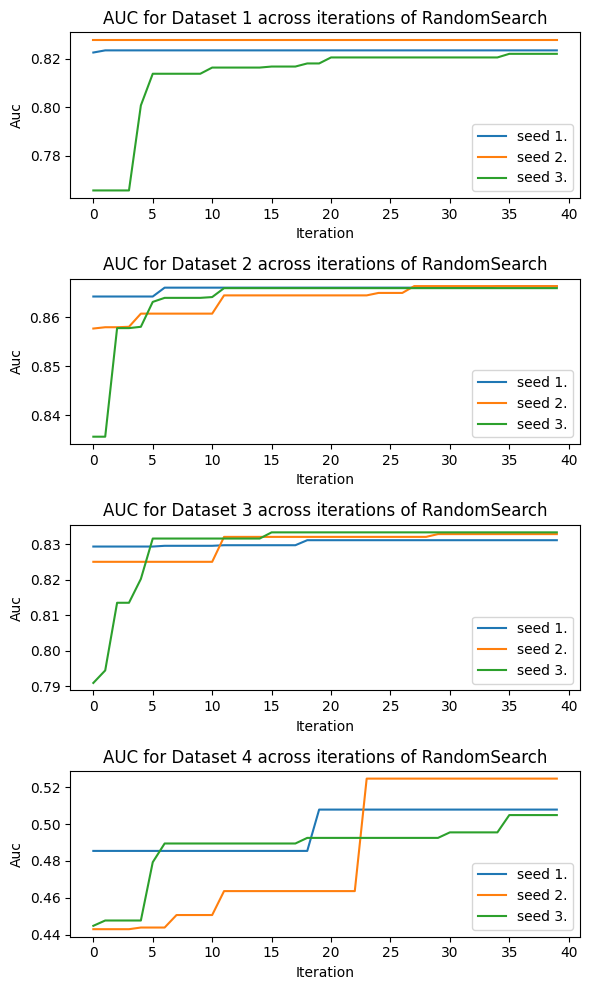

In [ ]:
x = [i for i in range(40)]

plt.figure(figsize=(6, 10))
for i in range(4):
  plot_auc(i,x,auc_list[i])

plt.tight_layout()
plt.show()

#### TUNEABILITY FOR PARAMS

In [ ]:
default = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'num_leaves': 31}

In [ ]:
param = ['learning_rate','max_depth', 'n_estimators','num_leaves']

#wider grid
param_grid = {
    'n_estimators': [i for i in range(20,301)],
    'learning_rate': [i/1000 for i in range(1,301)],
    'max_depth': [i for i in range(1,14)],
    'num_leaves': [i for i in range(10,101)]
}

lgb_classifier = lgb.LGBMClassifier()

lgb_state_list = [48,210,36]
df_results_list = []

for param_ in param:
  default_i = {'learning_rate': [0.01], 'max_depth': [3], 'n_estimators': [300], 'num_leaves': [31]}
  print(param_)
  default_i[param_] = param_grid[param_]

  df_result_param = []
  for l_state in(lgb_state_list):
    df_res,_ = find_rs(X_list,y_list,lgb_classifier,default_i,8,l_state)
    df_result_param.append(df_res)

  df_results_list.append(df_result_param)

In [ ]:
best_auc_list,best_params_list = find_param_list_across_seeds(df_results_list,param,lgb_state_list)

Parameter: learning_rate
Dataset 1 AUC: [0.7980426418158072, 0.7988739454269477, 0.8176205380430733]
learning_rate = 0.043
learning_rate = 0.003
learning_rate = 0.009
Dataset 2 AUC: [0.8660835530819826, 0.8660835530819826, 0.8657558570134131]
learning_rate = 0.043
learning_rate = 0.043
learning_rate = 0.057
Dataset 3 AUC: [0.8286640248111777, 0.8286640248111777, 0.8279336376711391]
learning_rate = 0.043
learning_rate = 0.043
learning_rate = 0.057
Dataset 4 AUC: [0.46769282178769317, 0.5069396208813858, 0.5052287365148406]
learning_rate = 0.043
learning_rate = 0.003
learning_rate = 0.009
Parameter: max_depth
Dataset 1 AUC: [0.8194208133793012, 0.8194208133793012, 0.8189195602464691]
max_depth = 3
max_depth = 3
max_depth = 10
Dataset 2 AUC: [0.8656741934387787, 0.8655662429191642, 0.8656741934387787]
max_depth = 8
max_depth = 10
max_depth = 8
Dataset 3 AUC: [0.8336889553517413, 0.8338637635212242, 0.8336889553517413]
max_depth = 12
max_depth = 13
max_depth = 12
Dataset 4 AUC: [0.50368967

For learning_rate diff across datasets: [-0.014575291571390592, 0.009241321059126117, 0.0051175624311647905, -0.010402940272026873]
Mean: -0.002654837088281639

For max_depth diff across datasets: [-0.00016727099830948777, 0.008905209932240532, 0.010444224741568808, -0.0032054988892377123]
Mean: 0.003994166196565535

For n_estimators diff across datasets: [-0.0018310548711369945, -0.0015717868329427898, -0.0017084284764510294, 0.005981570138154146]
Mean: 0.0002175749894058332

For num_leaves diff across datasets: [-1.866206987832797e-07, -7.567242288342158e-08, -3.84644571527204e-07, -3.2596210075563903e-07]
Mean: -2.4322494848738607e-07



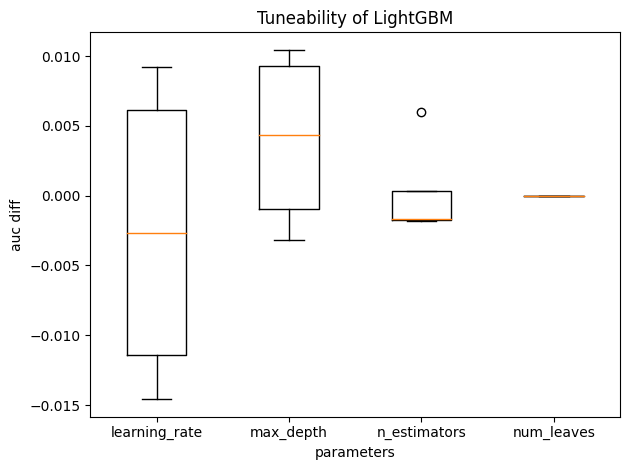

In [ ]:
default_lgb_auc  = [0.819421, 0.856733, 0.823303, 0.503690]
tun_param_lbm = []

for p in range(len(param)):
  param_diff = []
  for i in range(len(default_lgb_auc)):
    param_diff.append(np.mean(best_auc_list[p][i])-default_lgb_auc[i])
  tun_param_lbm.append(param_diff)

for p in range(len(param)):
  print(f"For {param[p]} diff across datasets: {tun_param_lbm[p]}")
  print(f"Mean: {np.mean(tun_param_lbm[p])}")
  print("")
plt.boxplot(tun_param_lbm, labels=param)
plt.title('Tuneability of LightGBM')
plt.xlabel('parameters')
plt.ylabel('auc diff')
plt.tight_layout()
plt.show()

## SMAC

zakresy searcha trzeba wziąć z tych użytych przy grid_search (czyli min i max z wektora w params_grid),
CV = 3 żeby wyniki były tak samo liczone

In [ ]:
from numpy.lib.function_base import add_newdoc
class SMAC:
  def __init__(self, classifier, X, y):
    self.classifier = classifier
    self.X = X
    self.y = y

  def train(self, config: Configuration, seed: int = 0, cv: int = 3, additional_params: dict = {}) -> float:
      classifier = self.classifier(random_state=seed, **dict(config), **additional_params)
      scores = cross_val_score(classifier, self.X, self.y, cv=cv, scoring='roc_auc')
      return np.mean(scores)


## Random Forest

In [ ]:
# Random Forest Hyperparameters
n_estimators = Integer("n_estimators", (50, 200), default=100)
max_depth = Integer("max_depth", (2,30), default=None)
min_samples_split = Integer("min_samples_split", (2, 20), default=2)
min_samples_leaf = Integer("min_samples_leaf", (2, 20), default=2)

### Algorithm Tunability

In [ ]:
from functools import partial

configspace = ConfigurationSpace()
configspace.add_hyperparameters([n_estimators, max_depth, min_samples_split, min_samples_leaf])

dfs = [df_1, df_2, df_3, df_4]
target_columns = ['OVERALL_DIAGNOSIS', 'class', 'Class', 'Class']

all_configs = []
for i in range(len(dfs)):
  X_train, y_train = dfs[i].drop(columns=[target_columns[i]]), dfs[i][target_columns[i]]
  smac_rf = SMAC(RandomForestClassifier, X_train, y_train)
  for seed in [0,10,20]:
    scenario = Scenario(configspace, deterministic=False, n_trials=10, seed=seed, name=f'df_{i+1}_seed_{seed}_n_trials_{10}')
    smac = HyperparameterOptimizationFacade(scenario, partial(smac_rf.train, seed=seed))
    incumbent = smac.optimize()
    optimized_dict = dict(incumbent)
    optimized_dict["df"] = i
    optimized_dict["seed"] = seed
    optimized_dict["score"] = smac_rf.train(dict(incumbent))
    all_configs.append(optimized_dict)
    print(optimized_dict)

In [ ]:
import pandas as pd

df = pd.DataFrame(all_configs)
df

,max_depth,min_samples_leaf,min_samples_split,n_estimators,df,seed,score
0,17,20,2,67,0,0,0.831598
1,5,12,12,182,0,10,0.836170
2,4,16,6,132,0,20,0.832426
3,24,5,16,116,1,0,0.860367
4,2,3,10,173,1,10,0.815737
5,4,16,6,132,1,20,0.837305
6,9,13,4,81,2,0,0.828261
7,3,17,9,173,2,10,0.795152
8,2,20,8,136,2,20,0.770956
9,26,6,14,134,3,0,0.469479


In [ ]:
df.groupby('df').agg({'score':'max'})

,score
df,
0,0.836170
1,0.860367
2,0.828261
3,0.469479


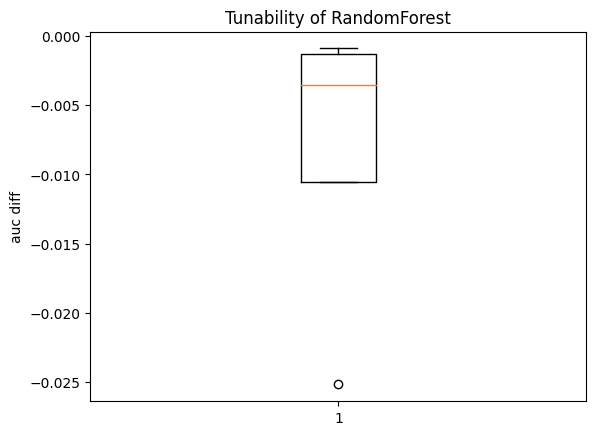

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
default_rf_auc = [0.841867,	0.861775,	0.829161,	0.494668]
tun_rf=np.subtract(list(df.groupby('df').agg({'score':'max'})["score"]), default_rf_auc)
plt.boxplot(tun_rf)
plt.title('Tunability of RandomForest')
plt.xlabel('')
plt.ylabel('auc diff')

plt.show()

### Parameter Tunability

In [ ]:
from functools import partial

default = {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 100}
hyperparams = [n_estimators, max_depth, min_samples_split, min_samples_leaf]

dfs = [df_1, df_2, df_3, df_4]
target_columns = ['OVERALL_DIAGNOSIS', 'class', 'Class', 'Class']

all_configs = []
for i in range(len(dfs)):
  X_train, y_train = dfs[i].drop(columns=[target_columns[i]]), dfs[i][target_columns[i]]
  smac_rf = SMAC(partial(RandomForestClassifier, max_depth=10,
                         min_samples_leaf=8, min_samples_split=2, n_estimators=100),
                  X_train, y_train)
  for param in hyperparams:
    configspace = ConfigurationSpace()
    configspace.add_hyperparameters([param])
    for seed in [0,10,20]:
      scenario = Scenario(configspace, deterministic=False, n_trials=10, seed=seed, name=f'df_{i+1}_seed_{seed}_n_trials_{10}_param_{param.name}')
      smac = HyperparameterOptimizationFacade(scenario, partial(smac_rf.train, seed=seed))
      incumbent = smac.optimize()
      optimized_dict = dict(incumbent)
      optimized_dict["df"] = i
      optimized_dict["seed"] = seed
      optimized_dict["score"] = smac_rf.train(dict(incumbent))
      optimized_dict["param"] = param.name
      all_configs.append(optimized_dict)
      print(optimized_dict)

In [ ]:
df = pd.DataFrame(all_configs)
df.to_csv("tunabilities_param.csv")
df

,n_estimators,df,seed,score,param,max_depth,min_samples_split,min_samples_leaf
0,158.0,0,0,0.838507,n_estimators,NaN,NaN,NaN
1,130.0,0,10,0.836993,n_estimators,NaN,NaN,NaN
2,104.0,0,20,0.830774,n_estimators,NaN,NaN,NaN
3,NaN,0,0,0.831746,max_depth,9.0,NaN,NaN
4,NaN,0,10,0.831746,max_depth,17.0,NaN,NaN
5,NaN,0,20,0.832329,max_depth,4.0,NaN,NaN
6,NaN,0,0,0.832569,min_samples_split,NaN,18.0,NaN
7,NaN,0,10,0.831746,min_samples_split,NaN,4.0,NaN
8,NaN,0,20,0.831746,min_samples_split,NaN,9.0,NaN
9,NaN,0,0,0.831041,min_samples_leaf,NaN,NaN,18.0


In [ ]:
default_rf_auc = [0.841867,	0.861775,	0.829161,	0.494668]

df_groupped = df.groupby(["df", "param"]).agg({"score": "mean"}).reset_index()
df_groupped

,df,param,score
0,0,max_depth,0.831940
1,0,min_samples_leaf,0.829817
2,0,min_samples_split,0.832020
3,0,n_estimators,0.835425
4,1,max_depth,0.833133
5,1,min_samples_leaf,0.859816
6,1,min_samples_split,0.861143
7,1,n_estimators,0.860631
8,2,max_depth,0.797611
9,2,min_samples_leaf,0.827465


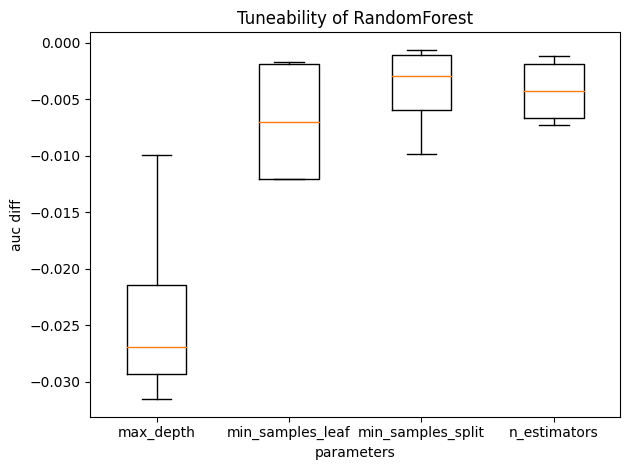

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
default_rf_auc = [0.841867,	0.861775,	0.829161,	0.494668]
replication_counts = [4, 4, 4, 4]
final_vector = [elem for elem, count in zip(default_rf_auc, replication_counts) for _ in range(count)]

df_groupped["score"] = np.subtract(df_groupped["score"], final_vector)
grouped_data = [df_groupped[df_groupped['param'] == name]['score'].tolist() for name in df_groupped['param'].unique()]


plt.boxplot(grouped_data, labels=df_groupped["param"].unique())
plt.title('Tuneability of RandomForest')
plt.xlabel('parameters')
plt.ylabel('auc diff')
plt.tight_layout()
plt.show()

## XGBoost

In [ ]:
# XGBoost Hyperparameters
n_estimators = Integer("n_estimators", (50, 200), default=100)
learning_rate = Float("learning_rate", (0.01, 0.2), default=0.2)
max_depth = Integer("max_depth", (3,10))

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_1.loc[:, 'OVERALL_DIAGNOSIS'] = le.fit_transform(df_1.loc[:,'OVERALL_DIAGNOSIS'])
df_2.loc[:, 'class'] = le.fit_transform(df_2.loc[:,'class'])
df_3.loc[:, 'Class'] = le.fit_transform(df_3.loc[:,'Class'])
df_4.loc[:, 'Class'] = le.fit_transform(df_4.loc[:,'Class'])

### Algorithm Tunability

In [ ]:
dfs = [df_1, df_2, df_3, df_4]
target_columns = ['OVERALL_DIAGNOSIS', 'class', 'Class', 'Class']
for i in range(len(dfs)):
  X_train, y_train = dfs[i].drop(columns=[target_columns[i]]), dfs[i][target_columns[i]]
  smac_rf = SMAC(partial(XGBClassifier, enable_categorical=True), X_train, y_train)
  print(smac_rf.train({'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 200}))

0.8248267382070199
0.8610220197433166
0.8262843815764201
0.49794871700888077


In [ ]:
from functools import partial

configspace = ConfigurationSpace()
configspace.add_hyperparameters([n_estimators, learning_rate, max_depth])

dfs = [df_1, df_2, df_3, df_4]
target_columns = ['OVERALL_DIAGNOSIS', 'class', 'Class', 'Class']

all_configs = []
for i in range(len(dfs)):
  X_train, y_train = dfs[i].drop(columns=[target_columns[i]]), dfs[i][target_columns[i]]
  smac_rf = SMAC(partial(XGBClassifier, enable_categorical=True), X_train, y_train)
  for seed in [0,10,20]:
    scenario = Scenario(configspace, deterministic=False, n_trials=50, seed=seed, name=f'xgb_df_{i+1}_seed_{seed}_n_trials_{50}')
    smac = HyperparameterOptimizationFacade(scenario, partial(smac_rf.train, seed=seed))
    incumbent = smac.optimize()
    optimized_dict = dict(incumbent)
    optimized_dict["df"] = i
    optimized_dict["seed"] = seed
    optimized_dict["score"] = smac_rf.train(dict(incumbent))
    all_configs.append(optimized_dict)
    print(optimized_dict)

In [ ]:
import pandas as pd

df = pd.DataFrame(all_configs)
df.groupby('df').agg({'score':'max'})

,score
df,
0,0.785967
1,0.843623
2,0.803284
3,0.430408


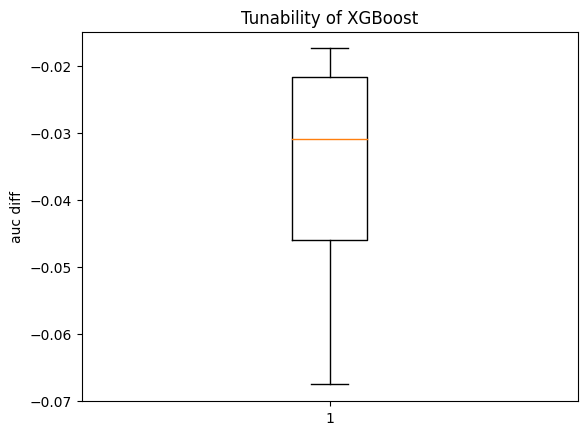

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
default_rf_auc = [0.824827, 0.861022, 0.826284, 0.497949]
tun_rf=np.subtract(list(df.groupby('df').agg({'score':'max'})["score"]), default_rf_auc)
plt.boxplot(tun_rf)
plt.title('Tunability of XGBoost')
plt.xlabel('')
plt.ylabel('auc diff')

plt.show()

### Parameter Tunability

In [ ]:
from functools import partial

default = {'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 200}
hyperparams = [n_estimators, max_depth, learning_rate]

dfs = [df_1, df_2, df_3, df_4]
target_columns = ['OVERALL_DIAGNOSIS', 'class', 'Class', 'Class']

all_configs = []
for i in range(len(dfs)):
  X_train, y_train = dfs[i].drop(columns=[target_columns[i]]), dfs[i][target_columns[i]]
  smac_rf = SMAC(partial(XGBClassifier, **default, enable_categorical=True),
                  X_train, y_train)
  for param in hyperparams:
    configspace = ConfigurationSpace()
    configspace.add_hyperparameters([param])
    for seed in [0,10,20]:
      scenario = Scenario(configspace, deterministic=False, n_trials=5, seed=seed, name=f'Xgb_df_{i+1}_seed_{seed}_n_trials_{5}_param_{param.name}')
      smac = HyperparameterOptimizationFacade(scenario, partial(smac_rf.train, seed=seed))
      incumbent = smac.optimize()
      optimized_dict = dict(incumbent)
      optimized_dict["df"] = i
      optimized_dict["seed"] = seed
      optimized_dict["score"] = smac_rf.train(dict(incumbent))
      optimized_dict["param"] = param.name
      all_configs.append(optimized_dict)
      print(optimized_dict)

In [ ]:
df = pd.DataFrame(all_configs)
df.to_csv("tunabilities_param.csv")
default_rf_auc = [0.824827, 0.861022, 0.826284, 0.497949]

df_groupped = df.groupby(["df", "param"]).agg({"score": "mean"}).reset_index()
df_groupped

,df,param,score
0,0,learning_rate,0.796396
1,0,max_depth,0.810184
2,0,n_estimators,0.808808
3,1,learning_rate,0.860958
4,1,max_depth,0.849571
5,1,n_estimators,0.846411
6,2,learning_rate,0.819213
7,2,max_depth,0.820070
8,2,n_estimators,0.811037
9,3,learning_rate,0.450460


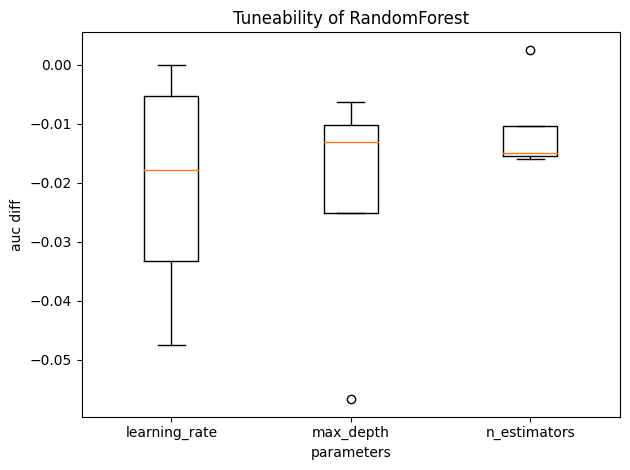

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
default_rf_auc = [0.824827, 0.861022, 0.826284, 0.497949]
replication_counts = [3]*4
final_vector = [elem for elem, count in zip(default_rf_auc, replication_counts) for _ in range(count)]

df_groupped["score"] = np.subtract(df_groupped["score"], final_vector)
grouped_data = [df_groupped[df_groupped['param'] == name]['score'].tolist() for name in df_groupped['param'].unique()]


plt.boxplot(grouped_data, labels=df_groupped["param"].unique())
plt.title('Tuneability of RandomForest')
plt.xlabel('parameters')
plt.ylabel('auc diff')
plt.tight_layout()
plt.show()

## LightGBM

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb

# LightGBM Hyperparameters
n_estimators = Integer("n_estimators", (20, 300), default=100)
learning_rate = Float("learning_rate", (0.01, 0.3), default=0.1)
max_depth = Integer("max_depth", (3,10))
num_leaves = Integer("num_leaves", (10, 100), default=31)

In [ ]:
light_gbm_auc_default = [0.819421, 0.856733, 0.823303, 0.503690]

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_1.loc[:, 'OVERALL_DIAGNOSIS'] = le.fit_transform(df_1.loc[:,'OVERALL_DIAGNOSIS'])
df_2.loc[:, 'class'] = le.fit_transform(df_2.loc[:,'class'])
df_3.loc[:, 'Class'] = le.fit_transform(df_3.loc[:,'Class'])
df_4.loc[:, 'Class'] = le.fit_transform(df_4.loc[:,'Class'])

### Algorithm Tunability

In [ ]:
from functools import partial

configspace = ConfigurationSpace()
configspace.add_hyperparameters([n_estimators, learning_rate, max_depth, num_leaves])

dfs = [df_1, df_2, df_3, df_4]
target_columns = ['OVERALL_DIAGNOSIS', 'class', 'Class', 'Class']

all_configs = []
for i in range(len(dfs)):
  X_train, y_train = dfs[i].drop(columns=[target_columns[i]]), dfs[i][target_columns[i]]
  smac_rf = SMAC(partial(lgb.LGBMClassifier, verbose=-1), X_train, y_train)
  for seed in [0,10,20]:
    scenario = Scenario(configspace, deterministic=False, n_trials=50, seed=seed, name=f'lgbm_df_{i+1}_seed_{seed}_n_trials_{50}_v2')
    smac = HyperparameterOptimizationFacade(scenario, partial(smac_rf.train, seed=seed))
    incumbent = smac.optimize()
    optimized_dict = dict(incumbent)
    optimized_dict["df"] = i
    optimized_dict["seed"] = seed
    optimized_dict["score"] = smac_rf.train(dict(incumbent))
    all_configs.append(optimized_dict)
    print(optimized_dict)

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 40 to 12 (max_ratio == 0.25).
[WARNING][target_function_runner.py:72] The argument cv is not set by SMAC: Consider removing it from the target function.
[WARNING][target_function_runner.py:72] The argument additional_params is not set by SMAC: Consider removing it from the target function.
[INFO][abstract_initial_design.py:147] Using 12 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:515] Added config 156c70 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:590] Added config a17581 and rejected config 156c70 as incumbent because it is not better than the incumbents on 2 instances:
[INFO][abstract_intensifier.py:590] Added config 480a8a and rejected config a17581 as incumbent because it is not better than the incumbents on 3 instances:
[INFO][smbo.py:319] Finished 50 trials.
[INFO][smbo.py:327] Configuration budget is e

In [ ]:
import pandas as pd

df = pd.DataFrame(all_configs)
df.groupby('df').agg({'score':'max'})

,score
df,
0,0.754182
1,0.833207
2,0.791148
3,0.435852


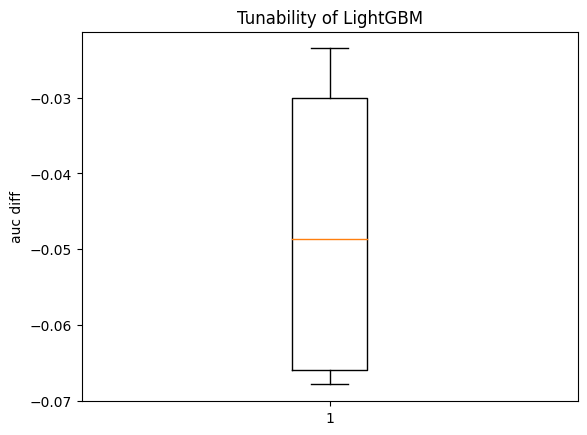

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
light_gbm_auc_default = [0.819421, 0.856733, 0.823303, 0.503690]
tun_rf=np.subtract(list(df.groupby('df').agg({'score':'max'})["score"]), light_gbm_auc_default)
plt.boxplot(tun_rf)
plt.title('Tunability of LightGBM')
plt.xlabel('')
plt.ylabel('auc diff')

plt.show()

### Parameter Tunability

In [ ]:
from functools import partial

default = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'num_leaves': 31}
hyperparams = [n_estimators, max_depth, learning_rate, num_leaves]

dfs = [df_1, df_2, df_3, df_4]
target_columns = ['OVERALL_DIAGNOSIS', 'class', 'Class', 'Class']

all_configs = []
for i in range(len(dfs)):
  X_train, y_train = dfs[i].drop(columns=[target_columns[i]]), dfs[i][target_columns[i]]
  smac_rf = SMAC(partial(lgb.LGBMClassifier, verbose=-1, **default),
                  X_train, y_train)
  for param in hyperparams:
    configspace = ConfigurationSpace()
    configspace.add_hyperparameters([param])
    for seed in [0,10,20]:
      scenario = Scenario(configspace, deterministic=False, n_trials=5, seed=seed, name=f'Lgbm_df_{i+1}_seed_{seed}_n_trials_{5}_param_{param.name}')
      smac = HyperparameterOptimizationFacade(scenario, partial(smac_rf.train, seed=seed))
      incumbent = smac.optimize()
      optimized_dict = dict(incumbent)
      optimized_dict["df"] = i
      optimized_dict["seed"] = seed
      optimized_dict["score"] = smac_rf.train(dict(incumbent))
      optimized_dict["param"] = param.name
      all_configs.append(optimized_dict)
      print(optimized_dict)

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 10 to 1 (max_ratio == 0.25).
[WARNING][target_function_runner.py:72] The argument cv is not set by SMAC: Consider removing it from the target function.
[WARNING][target_function_runner.py:72] The argument additional_params is not set by SMAC: Consider removing it from the target function.
[INFO][abstract_initial_design.py:147] Using 1 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:515] Added config 11bf19 as new incumbent because there are no incumbents yet.
[INFO][smbo.py:327] Configuration budget is exhausted:
[INFO][smbo.py:328] --- Remaining wallclock time: inf
[INFO][smbo.py:329] --- Remaining cpu time: inf
[INFO][smbo.py:330] --- Remaining trials: 0
{'n_estimators': 94, 'df': 0, 'seed': 0, 'score': 0.7979326249897043, 'param': 'n_estimators'}
[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 10 to 1 (max_rat

In [ ]:
df = pd.DataFrame(all_configs)
df.to_csv("tunabilities_param.csv")
default_rf_auc = [0.819421, 0.856733, 0.823303, 0.503690]

df_groupped = df.groupby(["df", "param"]).agg({"score": "mean"}).reset_index()
df_groupped

,df,param,score
0,0,learning_rate,0.756867
1,0,max_depth,0.818920
2,0,n_estimators,0.785985
3,0,num_leaves,0.819421
4,1,learning_rate,0.849251
5,1,max_depth,0.858960
6,1,n_estimators,0.821547
7,1,num_leaves,0.856733
8,2,learning_rate,0.805302
9,2,max_depth,0.825235


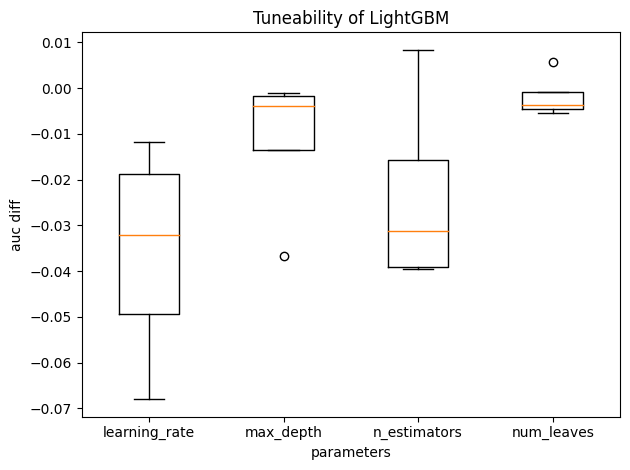

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
default_rf_auc = [0.824827, 0.861022, 0.826284, 0.497949]
replication_counts = [4]*4
final_vector = [elem for elem, count in zip(default_rf_auc, replication_counts) for _ in range(count)]

df_groupped["score"] = np.subtract(df_groupped["score"], final_vector)
grouped_data = [df_groupped[df_groupped['param'] == name]['score'].tolist() for name in df_groupped['param'].unique()]


plt.boxplot(grouped_data, labels=df_groupped["param"].unique())
plt.title('Tuneability of LightGBM')
plt.xlabel('parameters')
plt.ylabel('auc diff')
plt.tight_layout()
plt.show()